In [1]:
%tensorflow_version 1.x
!pip3 install shap

TensorFlow 1.x selected.
     |████████████████████████████████| 276kB 6.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394130 sha256=100dcc4843b45fc3ad582042371715bcbf529b9437a7dd53efcc1392f0f3ac6a
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 18s 0us/step



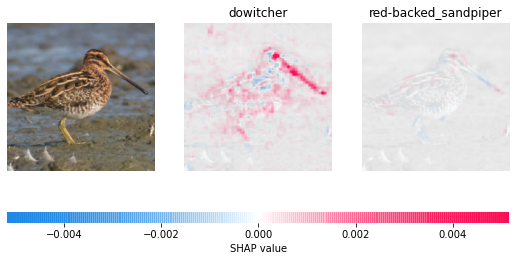

In [2]:
# copied from the shap examples shap/notebooks/deep_explainer but reduced input to one image instead of 2, for simplicity
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [3]:
# dimensions of first image
to_explain.shape

(1, 224, 224, 3)

In [10]:
!wget lemay.ai/img/hat_girl.jpg

--2020-07-19 16:10:56--  http://lemay.ai/img/hat_girl.jpg
Resolving lemay.ai (lemay.ai)... 167.99.176.220
Connecting to lemay.ai (lemay.ai)|167.99.176.220|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.lemay.ai/img/hat_girl.jpg [following]
--2020-07-19 16:10:57--  https://www.lemay.ai/img/hat_girl.jpg
Resolving www.lemay.ai (www.lemay.ai)... 167.99.176.220
Connecting to www.lemay.ai (www.lemay.ai)|167.99.176.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68369 (67K) [image/jpeg]
Saving to: ‘hat_girl.jpg’

hat_girl.jpg        100%[===================>]  66.77K  --.-KB/s    in 0.09s   

2020-07-19 16:10:57 (748 KB/s) - ‘hat_girl.jpg’ saved [68369/68369]



227 430 3
224 224 3


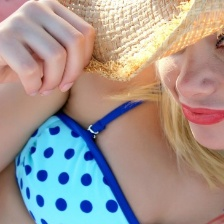

In [41]:
%matplotlib inline

#with code from https://stackoverflow.com/questions/46236180/opencv-imshow-will-cause-jupyter-notebook-crash/52061135
#with code from https://medium.com/@manivannan_data/resize-image-using-opencv-python-d2cdbbc480f0
import cv2
import matplotlib.pyplot as plt
from google.colab import files

filename = 'hat_girl.jpg'
W = 430.
oriimg = cv2.imread(filename)
height, width, depth = oriimg.shape
imgScale = W/width
newX,newY = oriimg.shape[1]*imgScale, oriimg.shape[0]*imgScale
newimg = cv2.resize(oriimg,(int(newX),int(newY)))
newimg.shape
crop_img = newimg[:224, :224,:]
cv2.waitKey(0)
cv2.imwrite("cropimg.jpg",crop_img)
height, width, depth = newimg.shape
print(height, width, depth)
height, width, depth = crop_img.shape
print(height, width, depth)
# files.download('resizeimg.jpg')

# from IPython.display import Image
Image(filename='cropimg.jpg') 

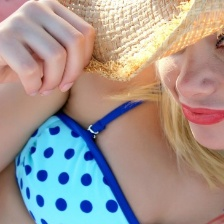

In [42]:
from IPython.display import Image
Image(filename='cropimg.jpg') 

In [43]:
to_explain = crop_img[np.newaxis,:,:,:].astype(float)
print(to_explain.shape)

(1, 224, 224, 3)


#Preprocessing is compete. Let's get to work.
## What classes does the model see? What pixels contribute or detract from these classifications?

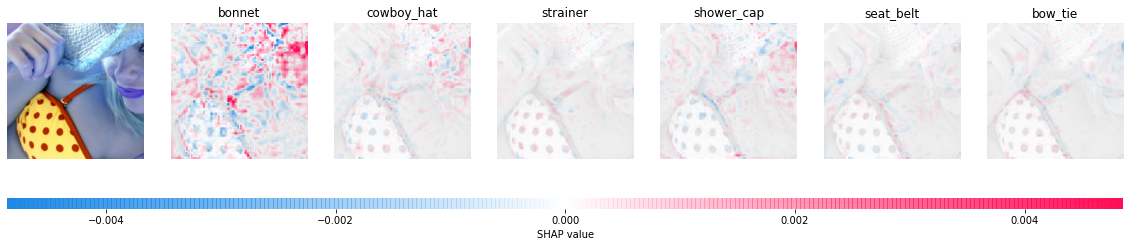

In [44]:
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=6)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)


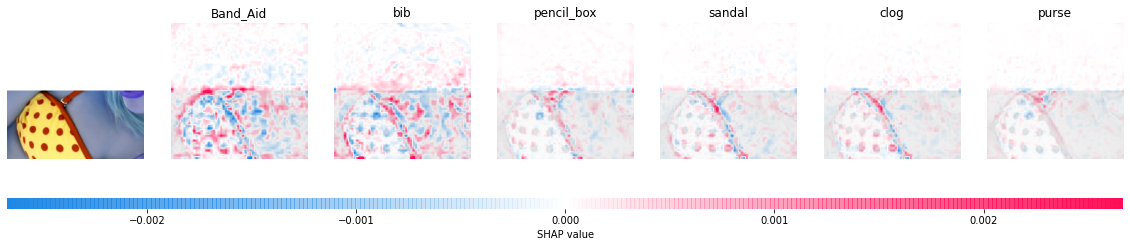

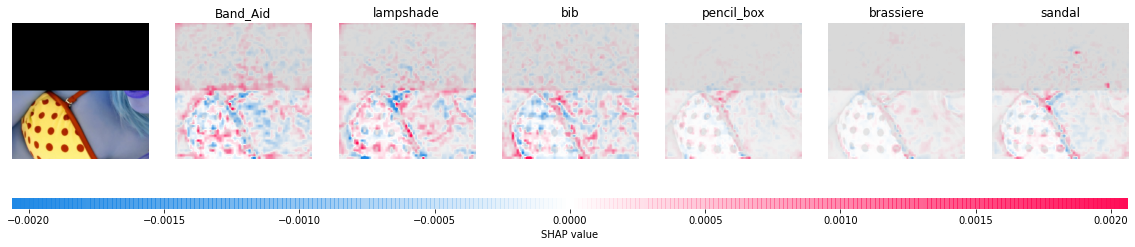

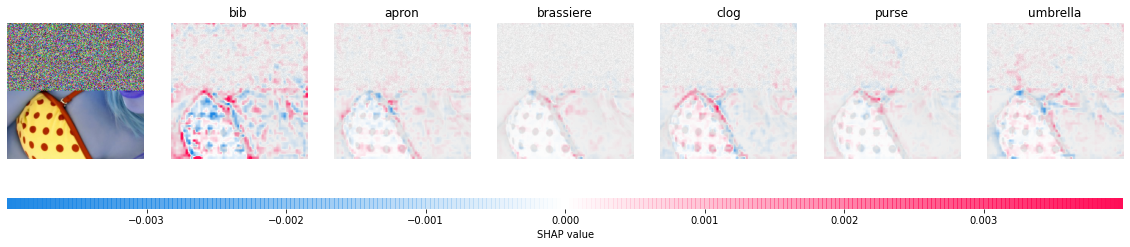

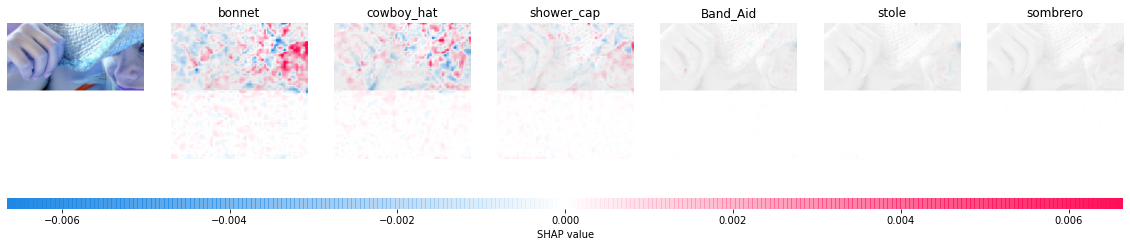

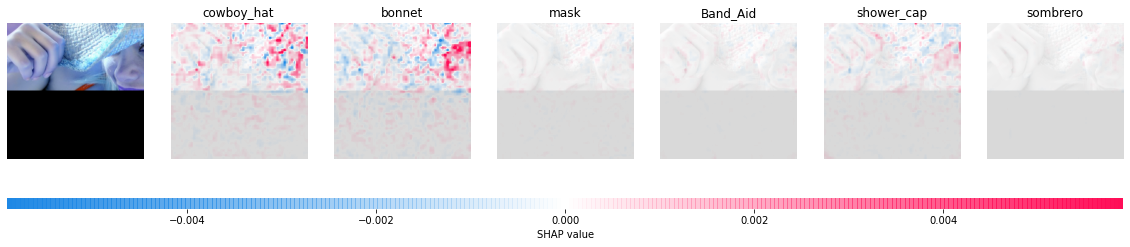

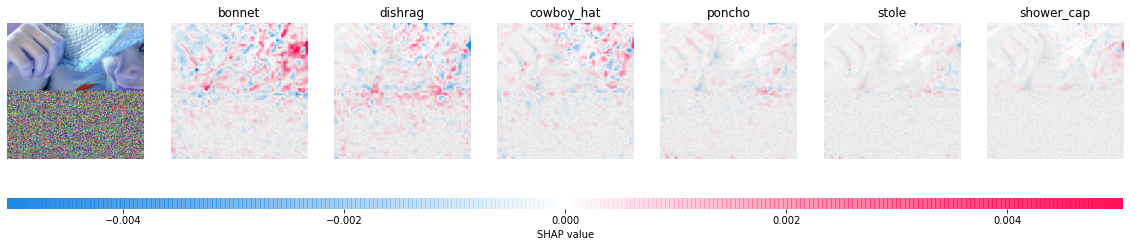

In [45]:
import copy
import random

masked_top_w = copy.deepcopy(to_explain)
masked_top_b = copy.deepcopy(to_explain)
masked_top_r = copy.deepcopy(to_explain)
masked_bottom_w = copy.deepcopy(to_explain)
masked_bottom_b = copy.deepcopy(to_explain)
masked_bottom_r = copy.deepcopy(to_explain)

#mask the top half of the image with black or white
for i in range(0,112):
  for j in range(224):
    for c in range(3):
      masked_top_b[0][i][j][c]=0.
      masked_top_w[0][i][j][c]=255.
      masked_top_r[0][i][j][c]=float(random.randint(0,255))
      

masked = copy.deepcopy(to_explain)
for i in range(112,224):
  for j in range(224):
    for c in range(3):
      masked_bottom_b[0][i][j][c]=0.
      masked_bottom_w[0][i][j][c]=255.
      masked_bottom_r[0][i][j][c]=float(random.randint(0,255))

maskedImages = [masked_top_w, masked_top_b,masked_top_r,masked_bottom_w,masked_bottom_b,masked_bottom_r]

for masked in maskedImages:
  shap_values,indexes = e.shap_values(map2layer(masked, 7), ranked_outputs=6)

  # get the names for the classes
  index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

  # plot the explanations
  shap.image_plot(shap_values, masked, index_names)